# Model Pipelines

Los objetivos de aprendizaje son:

1. Motivación
2. Pipeline
    - Preparación de datos.
    - Excluir regresores.
    - Inpute y Transformers.
    - Sampling.
    - Ensemble classifier.
    - Hyperparameter tuning.
    - Importancia de regresores.


## Motivación

La limpieza y preparación de datos (*feature engineering*) es la tarea que consume más recursos cuando creamos un modelo de ML:

- Estandarizar datos.
- Codificar los valores de las variables categóricas.
- Gestionar datos nulos `nan`s.
- Reducir la dimensionalidad.

Afortunadamente `sklearn` ha implementado la clase [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) que nos permite aplicar de manera secuencial una transformaciones para luego ajustar un estimador.

El uso de `Pipelines`en nuestro proyect brinda:

- Mejor estructura del flujo de trabajo.
- Reproducibilidad.
- Previene data leakage.
- Facilita la validación de nuestro modelo.


Tomemos como ejemplo:

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])

transformer = PolynomialFeatures(degree=2, include_bias=False)
transformer.fit(x)
x_ = transformer.transform(x)
model = LinearRegression().fit(x_, y)
x_new = np.array([10]).reshape((-1,1))
model.predict(x_new)

En este caso el flujo es muy sencillo y es mu fácil ver que olvidamos aplicar la transformación `PolynomialFeatures`. Pero en flujos más complejos:

- Podría ser muy difícil descubir el error.

- Podríamos no darnos cuenta que hay un error.


## Pipeline

El siguiente diagrama muestra el producto final de este notebook:

<div>
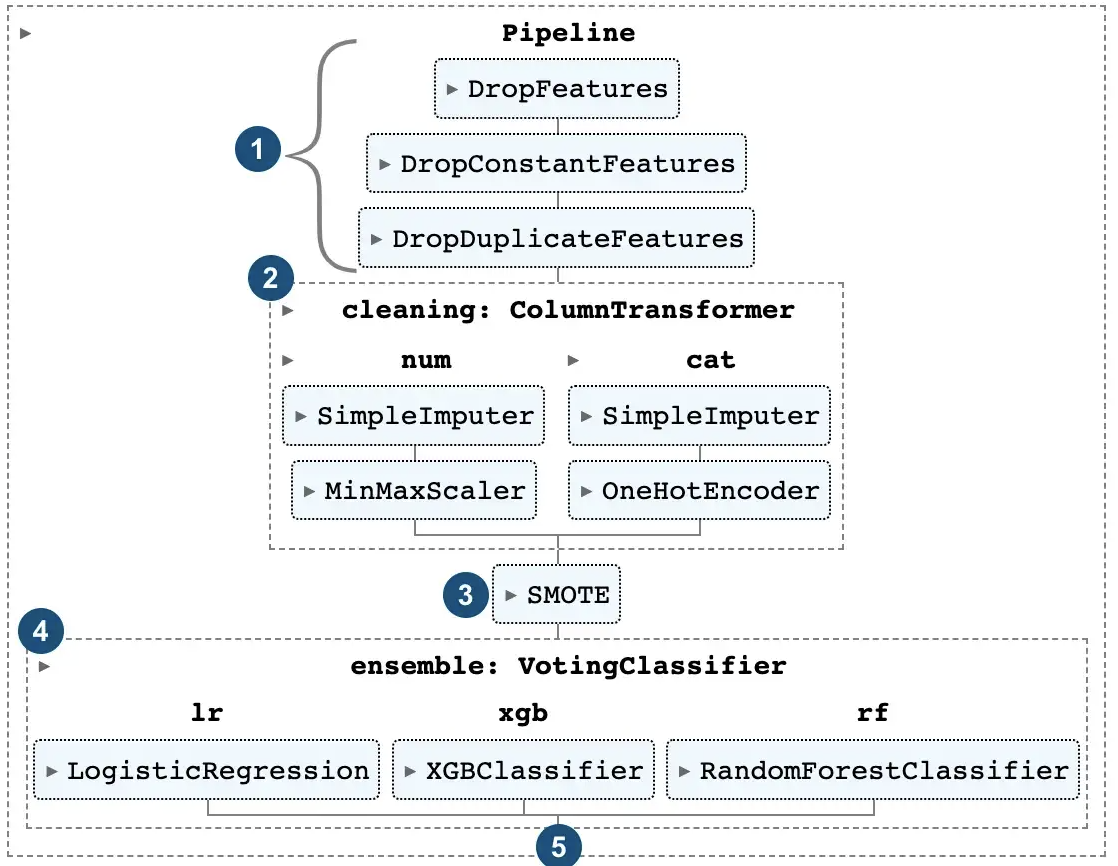
</div>

Implementaremos:

1. Descartar features irrelevantes.
2. Gestión de datos nulos y estandarización de features.
3. Equilibrar las clases del target.
4. Modelo ensamblado del tipo *VotingClassifier*.
5. Optimización de hiperparámetros

>**Nota**: El EDA, creación de features, selección de modelo, e interpretación de resultados no forman parte de scope de esta notebook.


### Preparación de datos.

Antes de configurar nuestra `Pipeline`, tenemos que cargar los paquetes necesarios y los datos.

El siguiente código muestra los paquetes y módulos necesarios para esta clase.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Validación de Estimadores 
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, 
                                     RepeatedStratifiedKFold, cross_validate)

# Pipeline
from sklearn import set_config
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Remover features no valiosas
from feature_engine.selection import (DropFeatures, DropConstantFeatures, 
                                      DropDuplicateFeatures)

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Modelos
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform

# Visualizar pipeline.
set_config(display="diagram")  

Además de los paquetes ya conocidos usaremos:

1. [`xgboost`](https://xgboost.readthedocs.io/en/stable/python/python_intro.html): Un paquete que implementa el algoritmo regularizing gradient boosting.

2. `loguniform`: Un módulo de scipy que usaremos para la optimización de hyperparámetros.

3. [`Imblearn`](https://imbalanced-learn.org/stable/): Un paquete que implementa herramientas para trabajar con problemas de clasificación desequilibrados.

4. [`Feature-Engine`](https://feature-engine.readthedocs.io/en/latest/): Un paquete con múltiples transformadores para diseñar y seleccionar features para usar en modelos ML.

#### Datos

Usaremos un set de datos llamado *Newspaper churn*, los datos fueron usados para una competencia en [Kaggle](https://www.kaggle.com/datasets/andieminogue/newspaper-churn) y son de dominio público. Contiene 15.855 registros y 19 columnas incluyendo la variable objetivo Suscriptor (YES/NO). La mayoría de las features son categóricas.

El siguiente código carga los datos y aplica los siguientes pasos:

1. Poner todos los nombres de las columnas en minúsculas.

2. Convertir el target variable a booleano.

3. Convertir las columnas string a categóricas.

4. Crear $X$ e $y$ 

5. Dividir los datos en:
    - Datos de entrenamiento.
    - Dtos de validación.

In [4]:
data = pd.read_excel("NewspaperChurn new version.xlsx")
data.columns = [col.lower().replace(" ", "_") for col in data.columns]

data.rename(
    columns={'subscriber':'churn'},
    inplace=True
)

data['churn'].replace(
    to_replace={'NO':False, 'YES':True},
    inplace=True
)

data[data.select_dtypes(['object']).columns] = data.select_dtypes(
    include=['object']
).apply(
    lambda x: x.astype('category')
)
data = data.sample(frac=0.075)


X = data.drop("churn", axis=1)
y = data["churn"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


Después de aplicar los pasos, los datos han quedado así:

In [5]:
data.head(5)

,subscriptionid,hh_income,home_ownership,ethnicity,dummy_for_children,year_of_residence,age_range,language,address,state,city,county,zip_code,weekly_fee,deliveryperiod,nielsen_prizm,reward_program,source_channel,churn
14955,140371710,"$ 50,000 - $59,999",OWNER,English,Y,32,60-64,English,8572 PHLOX DR,CA,BUENA PARK,ORANGE,90620,$10.00 - $10.99,7Day,MW,0,CustCall,True
9849,110082173,"$100,000 - $124,999",OWNER,Chinese,N,26,55-59,Chinese,31516 SEA SHADOWS WAY,CA,LAGUNA NIGUEL,ORANGE,92677,$4.00 - $4.99,7Day,YW,0,CustCall,False
1960,181446460,"$ 30,000 - $39,999",RENTER,Hispanic,N,6,50-54,Spanish,1264 E MCFADDEN AVE UNIT C,CA,SANTA ANA,ORANGE,92705,$0.01 - $0.50,SunOnly,MM,0,Partner,True
11952,170348788,"$300,000 - $399,999",OWNER,German,N,23,55-59,English,5112 HARVARD AVE,CA,WESTMINSTER,ORANGE,92683,$8.00 - $8.99,7Day,MW,0,CustCall,True
5901,130193797,"$300,000 - $399,999",OWNER,Italian,N,28,60-64,English,20690 VIA AUGUSTO,CA,YORBA LINDA,ORANGE,92887,$0 - $0.01,Thu-Sun,MW,0,CircAdm,False


### Excluir regresores

El primer paso es excluir/descartar columnas que no nos ayudarán en nuestra predicción.

Por ejemplo:

- La columna `subscriptionid` Tiene el ID de los clientes, un valor único por registro.

- Feature que están duplicadas, i.e. tener la misma columna con los mismos valores dos veces o más

- Columnas con un valor constante.

In [6]:
ppl = Pipeline([
    # Paso 1: Eliminar features irrelevantes
    ('drop_columns', DropFeatures(['subscriptionid'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures())
])

El codigo anterior crea una instancia de la clase `Pipeline` y la asigna a la variable `ppl`. 

El `Pipeline` ahora tiene tres pasos, cada uno definido como una tupla, cuyo primer elemento es el nombre que damos al paso y el segundo es la transformación. 

>**Nota**: Para que una clase pueda ser considerada como transformación por el `Pipeline` tiene que implementar los métodos `.fit()` y `.transform()`

Las transformaciones añadidas son:

1. [`DropFeatures`](https://feature-engine.readthedocs.io/en/1.3.x/user_guide/selection/DropFeatures.html): Elimina una lista de columnas.

2. [`DropConstantFeatures`](https://feature-engine.readthedocs.io/en/1.1.x/selection/DropConstantFeatures.html): Elimina columnas con valores constantes o casi constantes.

3. [`DropDuplicateFeatures`](https://feature-engine.readthedocs.io/en/1.1.x/selection/DropDuplicateFeatures.html): Elimina features duplicadas.

>**Nota**: Estos son pasos que podríamos implementar en `pandas`, pero hacrlo fuera iría en contra de las ventajas que comentamos.

In [7]:
ppl

Pipeline(steps=[('drop_columns',
                 DropFeatures(features_to_drop=['subscriptionid'])),
                ('drop_constant_values',
                 DropConstantFeatures(missing_values='ignore')),
                ('drop_duplicates', DropDuplicateFeatures())])

### Impute y Transformers.

Ahora nos enfocamos en lidiar con los valores faltantes (`None`, `nan`, etc.) y la escala de las features. 

Nuestro conjunto de datos contiene diferentes tipos de columnas: enteras y categóricas. Es por eso que tenemos que definir dos flujos de trabajo separados.

In [8]:
ppl = Pipeline([
    # Paso 1: Eliminar features irrelevantes
    ('drop_columns', DropFeatures(['subscriptionid'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    
    # Paso 2: Impute & Transformers
    ('cleaning', ColumnTransformer([
        # Paso 2.1: Flujo de variables numéricas
        ('num',
         make_pipeline(
             SimpleImputer(strategy='mean'),
             MinMaxScaler(feature_range=(0, 1))
         ),
         make_column_selector(dtype_include='int64')
        ),
        # Paso 2.2 Flujo de variables categóricas
        ('cat', make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include='category')
        )
    ])
    )
])

Las transformaciones añadidas son:

- [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html):permite que diferentes columnas o subconjuntos de columnas se transformen por separado y las características generadas por cada transformador se concatenarán. Su único parámetro obligatorio es `transformers`, una lista de tuplas (nombre, transformer, columnas).
<br>

    - `num`: Sub-Pipeline Numérico:
        - [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html): Imputador univariante para completar valores faltantes, en este caso usamos la media.
        - [`MinMaxScaler`](eature_range=(0, 1))
<br>

    - `cat`: Sub-Pipeline Categórico:
        - [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html): Imputador univariante para completar valores faltantes, en este caso usamos la moda.
        - [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html): Crea una columna binaria (`True`, `False`) por cada nivel de cada variable categórica.


Para crear los Sub-Pipelines usamos la función [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html), que es un constructor de la clase `Pipeline`.

Para seleccionar las columnas usamos la función [`make_column_selector`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html) Que puede selaccionar la columans de un dataframe usando distintos patrones.

In [9]:
ppl

Pipeline(steps=[('drop_columns',
                 DropFeatures(features_to_drop=['subscriptionid'])),
                ('drop_constant_values',
                 DropConstantFeatures(missing_values='ignore')),
                ('drop_duplicates', DropDuplicateFeatures()),
                ('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a20da710>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a20db750>)]))])

### Sampling.

Un gran desafío en la clasificación de abandono o fraude es lidiar con el desequilibrio de clases.

`Imblearn` proporciona una batería de métodos de muestreo que podemos aplicar, veamos cómo incorporarlos al `Pipeline`

In [10]:
y_train.value_counts()/len(y_train)

False    0.815983
True     0.184017
Name: churn, dtype: float64

In [11]:
ppl = Pipeline([
    # Paso 1: Eliminar features irrelevantes
    ('drop_columns', DropFeatures(['subscriptionid'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    
    # Paso 2: Impute & Transformers
    ('cleaning', ColumnTransformer([
        # Paso 2.1: Flujo de variables numéricas
        ('num',make_pipeline(
            SimpleImputer(strategy='mean'),
            MinMaxScaler()),
         make_column_selector(dtype_include='int64')
        ),
        # Paso 2.2 Flujo de variables categóricas
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include='category')
        )])
    ),
    # Paso 3: Sampling
    ('smote', SMOTE())
])
ppl

Pipeline(steps=[('drop_columns',
                 DropFeatures(features_to_drop=['subscriptionid'])),
                ('drop_constant_values',
                 DropConstantFeatures(missing_values='ignore')),
                ('drop_duplicates', DropDuplicateFeatures()),
                ('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a20ce7d0>),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a20cd3d0>)])),
                ('smote', SMOTE())])

Las transformaciones añadidas son:

- [`SMOTE`](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html): Una clase que implementa [*Synthetic Minority Over-sampling*](https://arxiv.org/abs/1106.1813). Es una tecnica de muestreo que combina el sobremuestreo de la clase minoritaria y submuestreo de la clase mayoritaria.

Antes de construir nuestro clasificador, vamos a verificar qué features lograron pasar por el `Pipeline` y cómo se ven.

Para ello podemos usar el método `.get_feature_names_out()` de la clase `Pipeline`. Pero antes debemos llamar al método `.fit()` sobre nuestros datos. 

Dado que el el paso 3 `SMOTE` se centra sólo en `y` podemos ignorarlo por ahora.

In [12]:
ppl_fts = ppl[0:4]
ppl_fts.fit(X_train, y_train)
features = ppl_fts.get_feature_names_out()
pd.Series(features)

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0                   num__year_of_residence
1                            num__zip_code
2                      num__reward_program
3       cat__hh_income_$  20,000 - $29,999
4       cat__hh_income_$  30,000 - $39,999
                       ...                
1168            cat__source_channel_System
1169               cat__source_channel_TMC
1170            cat__source_channel_TeleIn
1171           cat__source_channel_TeleOut
1172               cat__source_channel_VRU
Length: 1173, dtype: object

Debido al `OneHotEncoder`, se han creado muchas features nuevas (`cat__<var name>_<category level>`).La convención de nomenclatura muestra si la feature es numérica o categorial (e.g., `cat__`). 

### Ensemble classifier.

Ahora es el momento de construir nuestro *Ensemble classifier*.

En este ejemplo, queremos usar los siguientes modelos:

1. [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): Es un caso particular de la familia de modelos lineales generalizados (GLMs), se usa para tareas de clasificación.
<br>

2. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): Es un modelo que ajusta una serie de árboles de decisión sobre varias submuestras ([Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))) del conjunto de datos y utiliza el promedio para disminuir el *model variance* y controlar el *over-fitting*.


3. [`XGBClassifier`](https://xgboost.readthedocs.io/en/stable/get_started.html): Implementación del algoritmo gradient boosted trees. Gradient boosting es un algoritmo de aprendizaje supervisado que intenta disminuir el *model bias* al combinar las estimaciones de un conjunto de modelos más simples y más débiles.

Ensamblaremos las predicciones de los tres medelos tomando la media, para ello usarmoes la clase [`VotingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html).

In [13]:
lr = LogisticRegression(
    warm_start=True,
    max_iter=400
)

rf = RandomForestClassifier()

xgb = XGBClassifier(
    tree_method="hist",
    verbosity=0,
    silent=True
)


lr_xgb_rf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('xgb', xgb),
        ('rf', rf)
    ], 
    voting='soft'
)

Después de definir los modelo, estamos listos para integrarlo en nuestra `Pipeline`.

In [14]:
ppl = imbPipeline([
    # Paso 1: Eliminar features irrelevantes
    ('drop_columns', DropFeatures(['subscriptionid'])),
    ('drop_constant_values', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    
    # Paso 2: Impute & Transformers
    ('cleaning', ColumnTransformer([
        # Paso 2.1: Flujo de variables numéricas
        ('num',make_pipeline(
            SimpleImputer(strategy='mean'),
            MinMaxScaler()),
         make_column_selector(dtype_include='int64')
        ),
        # Paso 2.2 Flujo de variables categóricas
        ('cat',make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse=False, handle_unknown='ignore')),
         make_column_selector(dtype_include='category')
        )])
    ),
    
    # Paso 3: Sampling
    ('smote', SMOTE()),
    
    # Paso 4: Voting Classifier
    ('ensemble', lr_xgb_rf)
])

En lugar de usar la clase `Pipeline` de sklearn, ahora estamos usando `imbPipeline` de imblearn.

Si no hiciéramos esto, obtendríamos el siguiente error al ajustar (ppl.fit(X_train, y_train)):

```Python
TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'SMOTE()' (type <class 'imblearn.over_sampling._smote.base.SMOTE'>) doesn't
```

In [15]:
ppl

Pipeline(steps=[('drop_columns',
                 DropFeatures(features_to_drop=['subscriptionid'])),
                ('drop_constant_values',
                 DropConstantFeatures(missing_values='ignore')),
                ('drop_duplicates', DropDuplicateFeatures()),
                ('cleaning',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose....
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)),
                                              ('rf', RandomForestClassifier())],
                                  voting='soft'))])

### Hyperparameter tuning

Al crear un modelo ML, tendremos que definir la arquitectura del estimado, por ejemplo la arquitectura por defecto del estimador `RandomForestClassifier` es:

```python
RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None
)
```
Los parámetros que definen la arquitectura del estimador se denominan hiperparámetros.

Al inicio no sabremos cuál debería es la arquitectura óptima del estimador, los parámetros que se asignan por defecto no funcionan en todos lo casos.

Al proceso de búsqueda de de la arquitectura óptima se le denomina *Hyperparameter tuning*.

Sklearn cuenta con la clase [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) que optimiza los hiperparámetros del estimador mediante una búsqueda de validación cruzada. A diferencia de `GridSearchCV`, no se prueban todos los valores de los parámetros, sino que se muestrea un número fijo de configuraciones de parámetros.

El siguiente código:

1. Declara un diccionario que contiene la configuración de los hiperparámetros siguiendo la nomenclatura:

    - LLaves:
        - `ensemble__`: Nombre que dimos a nuestro agregador en el `Pipeline`.
        - `<nombre estimador>__`: Nombre que le dimos a nuestro estimador dentro del `VotingClassifier`.
        - `<nombre del parámetro>`: Nombre del parámetro que queremos optimizar.
    - Valores: Iterable con el rango de valores que queremos probar.
<br>


2. Crea una instancia de la clase [`RepeatedStratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) que implementa una estrategia [estratificada](https://en.wikipedia.org/wiki/Stratified_sampling) de validación cruzada. La validación cruzada es un método de evaluación del performance de un estimador para averiguar qué tan bien puede predecir el resultado de los datos no vistos.
<br>

3. Crea una instancia de la clase `RandomizedSearchCV` que toma como parámetros:
    - `Pipeline`.
    - Configuración de hiperparámetros a optimizar.
    - La métrica a optimizar, [roc_auc](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).
    - La estrategia de validación cruzada.
    - El grado de verbosidad, grado de frecuenda con el que el algoritmo nos irá mostrando resultados.
<br>

4. Llamamos al método `.fit()` de la clase `RandomizedSearchCV`.

In [16]:
params = {
    'ensemble__lr__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'ensemble__lr__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'ensemble__lr__C': loguniform(1e-5, 100),
    'ensemble__xgb__learning_rate': [0.1],
    'ensemble__xgb__max_depth': [7, 10, 15, 20],
    'ensemble__xgb__min_child_weight': [10, 15, 20, 25],
    'ensemble__xgb__colsample_bytree': [0.8, 0.9, 1],
    'ensemble__xgb__n_estimators': [300, 400, 500, 600],
    'ensemble__xgb__reg_alpha': [0.5, 0.2, 1],
    'ensemble__xgb__reg_lambda': [2, 3, 5],
    'ensemble__xgb__gamma': [1, 2, 3],
    'ensemble__rf__max_depth': [7, 10, 15, 20],
    'ensemble__rf__min_samples_leaf': [1, 2, 4],
    'ensemble__rf__min_samples_split': [2, 5, 10],
    'ensemble__rf__n_estimators': [300, 400, 500, 600],
}

rsf = RepeatedStratifiedKFold(random_state=42)
clf = RandomizedSearchCV(ppl, params,scoring='roc_auc', verbose=2, cv=rsf, n_iter=5)
clf.fit(X_train, y_train)

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)
print("AUC:", roc_auc_score(y_val, clf.predict(X_val)))

Fitting 50 folds for each of 5 candidates, totalling 250 fits


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   2.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.8s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.7s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.7s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.7s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   2.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.6s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.8s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.7s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.5s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.6s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.3s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.5s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.7s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.5s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.5s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.6s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.5s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.5s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.5s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.3s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.3s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.04403095906910918, ensemble__lr__penalty=l2, ensemble__lr__solver=newton-cg, ensemble__rf__max_depth=20, ensemble__rf__min_samples_leaf=4, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=3, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=600, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   1.5s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   0.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   0.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   0.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   0.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.3s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.3s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.4s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   0.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   0.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   0.9s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ensemble__lr__C=0.07461683936506193, ensemble__lr__penalty=none, ensemble__lr__solver=lbfgs, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=400, ensemble__xgb__colsample_bytree=1, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=7, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/pyt

[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/pyt

[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/pyt

[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/pyt

[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/pyt

[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/pyt

[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/pyt

[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5; total time=   0.1s
[CV] END ensemble__lr__C=45.00868520338764, ensemble__lr__penalty=elasticnet, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=7, ensemble__rf__min_samples_leaf=2, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=300, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=300, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=5;

/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.0s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.012957029891630905, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=10, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=5, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=1, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=20, ensemble__xgb__min_child_weight=15, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=1, ensemble__xgb__reg_lambda=3; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.1s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END ensemble__lr__C=0.00046824251476405225, ensemble__lr__penalty=l2, ensemble__lr__solver=liblinear, ensemble__rf__max_depth=15, ensemble__rf__min_samples_leaf=1, ensemble__rf__min_samples_split=10, ensemble__rf__n_estimators=600, ensemble__xgb__colsample_bytree=0.8, ensemble__xgb__gamma=2, ensemble__xgb__learning_rate=0.1, ensemble__xgb__max_depth=15, ensemble__xgb__min_child_weight=10, ensemble__xgb__n_estimators=500, ensemble__xgb__reg_alpha=0.5, ensemble__xgb__reg_lambda=2; total time=   1.2s


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/heber.trujillo/projec

Best Score:  0.8144254283351057
Best Params:  {'ensemble__lr__C': 0.00046824251476405225, 'ensemble__lr__penalty': 'l2', 'ensemble__lr__solver': 'liblinear', 'ensemble__rf__max_depth': 15, 'ensemble__rf__min_samples_leaf': 1, 'ensemble__rf__min_samples_split': 10, 'ensemble__rf__n_estimators': 600, 'ensemble__xgb__colsample_bytree': 0.8, 'ensemble__xgb__gamma': 2, 'ensemble__xgb__learning_rate': 0.1, 'ensemble__xgb__max_depth': 15, 'ensemble__xgb__min_child_weight': 10, 'ensemble__xgb__n_estimators': 500, 'ensemble__xgb__reg_alpha': 0.5, 'ensemble__xgb__reg_lambda': 2}
AUC: 0.6682814890362061


### Importancia de regresores.

Una vez entrenado el modelo es muy probable que además de hacer predicciones querramos saber qué regresores son los más relevantes. Existen distintas opciones:

- [permutation importance](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html): Estima y clasifica la importancia de los regresores en función del impacto que cada regresor tiene en las predicciones del modelo. Lo hace evaluando cómo aumenta el error de predicción cuando un regresor no está disponible.

- [SHAP](https://shap.readthedocs.io/en/latest/): SHapley Additive exPlanations es un método basado en la teoría de juegos cooperativos.


Tomaremos un ejemplo de skleanr:

In [17]:
# https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """
    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])
    ax.set_yticks(range(len(indices)))
    ax.set_title("Permutation importance")
    
    tmp = np.array(feat_name)
    _ = ax.set_yticklabels(tmp[indices])

ppl_fts = ppl[0:4]
ppl_fts.fit(X_train, y_train)
features = ppl_fts.get_feature_names_out()

perm_importance_result_train = permutation_importance(clf, X_train, y_train, random_state=42)


/Users/heber.trujillo/projects/curso-python-cac/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


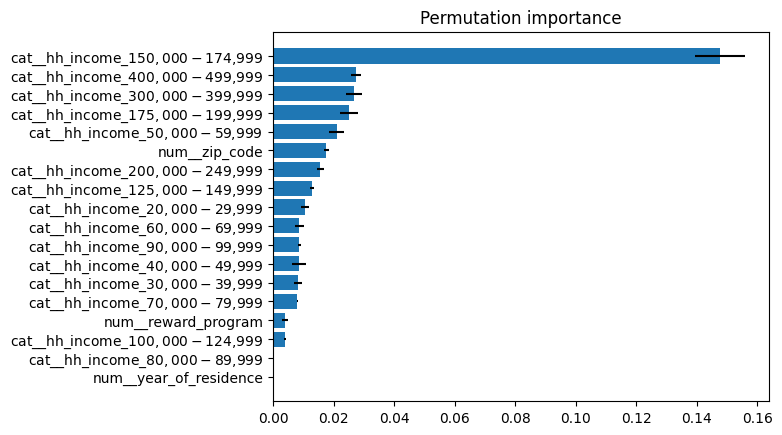

In [18]:
plot_feature_importances(perm_importance_result_train, features)